In [2]:
!pip install ijson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 3.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import json

In [5]:
import os
import ijson
import matplotlib.pyplot as plt
os.getcwd()

'/content'

# Loading JSON
business and review tables stored in JSON format in Google Drive

In [6]:
business = pd.read_json('/content/drive/MyDrive/W266 Notes/W266 Final Project/yelp_academic_dataset_business.json', lines=True)

In [7]:
business_explode = business.assign(categories = business.categories.str.split(', ')).explode('categories')
business_explode.categories.value_counts().head(10)

Restaurants         52268
Food                27781
Shopping            24395
Home Services       14356
Beauty & Spas       14292
Nightlife           12281
Health & Medical    11890
Local Services      11198
Bars                11065
Automotive          10773
Name: categories, dtype: int64

We will focus on restaurants for this project so will filter the business table accordingly based on the categories as shown above. Many businesses contain more detailed category descriptions ("Italian", "Bars") etc.

In [8]:
restaurants = business[business['categories'].str.contains(
              'Restaurants|Food',
              case=False, na=False)]

In [9]:
restaurants.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."


The review dataset is much larger and thus will require loading in chunks to avoid memory loss. Both the review and business tables contain a business_id which will be used to join the two tables.

In [10]:
size = 10000
review_json_path = '/content/drive/MyDrive/W266 Notes/W266 Final Project/yelp_academic_dataset_review.json'
review = pd.read_json(review_json_path, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=size)

In [11]:
# There are multiple chunks to be read
chunk_list = []
for chunk_review in review:
    # Renaming column name to avoid conflict with business overall star rating
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    # Inner merge with edited business file so only reviews related to food/restaurants remain
    chunk_merged = pd.merge(restaurants, chunk_review, on='business_id', how='inner')

    chunk_list.append(chunk_merged)
# After trimming down the review file, concatenate all relevant data back to one dataframe
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

# Filtering joined df
We filtered the joined restaurant-review dataset to only include restaurants that are still open, with more than 50 reviews from 2018 onwards. This was done to remove any outdated reviews that might not be currently representative of the restaurant, while also ensuring that a restaurant was popular enough to receive a sufficient number of reviews.



<ipython-input-12-0ad3434a02f5>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'date'] = pd.to_datetime(df['date'])


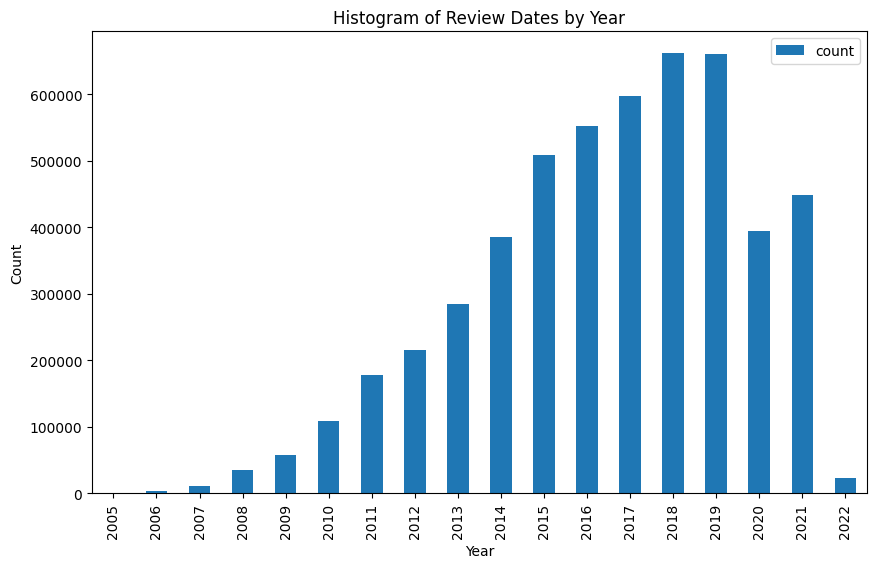

In [12]:
df.loc[:, 'date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

hist_data = df['year'].value_counts().reset_index().sort_values('index')
hist_data.columns = ['year', 'count']

hist_data.plot(kind='bar', x='year', y='count', figsize=(10, 6))

# Set the x-axis labels
plt.xlabel('Year')
plt.ylabel('Count')

# Set the plot title
plt.title('Histogram of Review Dates by Year')

# Display the plot
plt.show()


In [13]:
#filter for reviews 2018-onwards and only for restaurants with >50 reviews in this time range + open restaurants
df_filtered = df[df['year'] > 2017]

df_filtered = df_filtered[df_filtered['is_open'] == 1]

restaurant_counts = df_filtered['business_id'].value_counts()
filtered_counts = restaurant_counts[restaurant_counts >= 50]
filtered_restaurants = filtered_counts.index.tolist()

df_filtered = df_filtered[df_filtered['business_id'].isin(filtered_restaurants)]

#determine review importance and sort df by number of user votes
df_filtered['total_votes'] = df_filtered['useful'] + df_filtered['funny'] + df_filtered['cool']
df_sorted = df_filtered.sort_values(['business_id', 'total_votes', 'text'], ascending = [True, False, True])


<ipython-input-13-a17dd67fd966>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['total_votes'] = df_filtered['useful'] + df_filtered['funny'] + df_filtered['cool']


The below actions return the top 10 reviews (sorted by votes) and concatenates them into one string.

In [14]:
#Returns the top 10 reviews for each business by votes
df_top10 = df_sorted.groupby('business_id').head(10)

#Returns the top review for each business by votes
df_top1 = df_sorted.groupby('business_id').head(1)

#concatenate the top 10 reviews into one string
agg_methods = {col: 'first' if col != 'text' else lambda x: ' '.join(x) for col in df.columns}

df_concatenated = df_top10.groupby('business_id').agg(agg_methods)


df_concatenated = df_concatenated.rename(columns={'text': 'text_top10'}).reset_index(drop = True)
df_concatenated['review_words'] = df_concatenated['text_top10'].str.split().str.len()

df_concatenated.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,review_id,user_id,review_stars,useful,funny,cool,text_top10,date,year,review_words
0,-09Oc2D14vRnmirPh0vlXw,Cracker Barrel Old Country Store,110 Hancock Ln,Mount Holly,NJ,08060,40.028440,-74.815030,3.0,135,...,09ivYIwAJx2r9sKmjuh4hA,6pbNMgTnSYrtPHDN07IXwA,3,22,5,15,[953]\n7/2019\n\nThis Cracker Barrel is locate...,2019-07-22 21:58:10,2019,1660
1,-0FX23yAacC4bbLaGPvyxw,The Grey Stone Fine Food and Spirits,552 Washington Crossing Rd,Newtown,PA,18940,40.256082,-74.916976,3.5,155,...,JJss6JSQGIHxjzzNwCtt8Q,-G7Zkl1wIWBBmD0KRy_sCw,5,58,31,46,As soon as we walked in to Greystone it was ob...,2019-07-31 18:54:36,2019,3883
2,-0TffRSXXIlBYVbb5AwfTg,IndeBlue Modern Indian Food & Spirits,205 South 13th St,Philadelphia,PA,19107,39.948508,-75.161969,4.5,1097,...,I5XDILvCuRiF351arokrSw,BmVwbsL8l0imz4slonyMaA,4,36,11,30,Came here for the lunch special menu a little ...,2020-03-25 04:03:25,2020,1825
3,-0Ym1Wg3bXd_TDz8JtvOQg,Yelo'd Ice Cream,10150A 82 Ave,Edmonton,AB,T6E 1Z4,53.518487,-113.493183,4.5,105,...,LfHV5IrlxnYh1XwcWx971w,jZq51opDMNLWDWmnIOPc0w,5,12,7,12,We came here on a nice sunny afternoon to grab...,2021-04-25 21:48:08,2021,1789
4,-0gRYq5UjMtZbELj0KHxzA,La Colombe Coffee,"915 Lancaster Ave, Ste 160",Bryn Mawr,PA,19010,40.023408,-75.320947,3.5,128,...,v4X_QSR3FH1ZPsPp0j97kA,vU9_lZqJQIR8btUYw7fqxA,3,13,2,4,I was with a couple of family members visiting...,2019-04-21 23:31:56,2019,1639


In [15]:
df_concatenated.loc[0, 'text_top10']

'[953]\n7/2019\n\nThis Cracker Barrel is located right off exit 5 of the NJ turnpike.  It\'s very easy to access with plenty of parking. \n\nThe staff was nice.   We stopped in for breakfast which we enjoyed.  \n\nThe place is clean and there is a nice shop when you enter (like all other locations)\n\nWe will definitely be back This is one Cracker Barrel of the now 6 locations in NJ . It used to be only 2 at one time . This one is located right off the NJ Turnpike at exit 5. \n\nCracker Barrel is an affordable dining spot better known for breakfast but also serves lunch and dinner \n\nIt has a country and antique flair... rocking chairs upon walking in and cute store when you walk in that is fun to take a gander. \n\nStaff is always nice \n\nFood can be hit or miss  but I had a good meal at this location. I like the country fried steak. You get to choose several sides and get a complimentary corn bread and biscuit . I like the raspberry iced tea \n\nThey had the fireplace going when I 

In [28]:
print("Average length of each restaurant's top-rated review: " + str(round(df_top1['text'].str.split().str.len().mean(),1)))

print("Average length of each restaurant's top 10 reviews (concatenated): " + str(round(df_concatenated['review_words'].mean(),1)))


Average length of each restaurant's top-rated review: 203.2
Average length of each restaurant's top 10 reviews (concatenated): 1602.3


In [ ]:
df_top10.to_csv('/content/drive/MyDrive/W266 Notes/W266 Final Project/df_top10reviews.csv', index = False)

df_concatenated.to_csv('/content/drive/MyDrive/W266 Notes/W266 Final Project/df_concatenated.csv', index = False)

df_top1.to_csv('/content/drive/MyDrive/W266 Notes/W266 Final Project/df_top_review.csv', index = False)